## Mutual Fund Analysis

### Installing mftool

In [1]:
!pip install mftool

### Importing necessary packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Reading the Mutual Fund Names and their Scheme codes from dataset file

- File with Scheme Codes and their names is being read using mftool.

In [3]:
from mftool import Mftool
MF_obj = Mftool()
all_scheme_codes = MF_obj.get_scheme_codes()
MF_df = pd.DataFrame.from_dict(all_scheme_codes, orient='index')
MF_df.reset_index(inplace=True)
MF_df.columns=['Scheme code','MF Name']
MF_df.head(3)

,Scheme code,MF Name
0,119551,Aditya Birla Sun Life Banking & PSU Debt Fund ...
1,119552,Aditya Birla Sun Life Banking & PSU Debt Fund ...
2,119553,Aditya Birla Sun Life Banking & PSU Debt Fund ...


#### Checking number of MF schemes extracted

In [4]:
MF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14946 entries, 0 to 14945
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Scheme code  14946 non-null  object
 1   MF Name      14946 non-null  object
dtypes: object(2)
memory usage: 116.8+ KB


#### Extracting certain Mutual Funds based on the conditions

In [5]:
# Extracting MF schemes based on the following criteria

# change the values like 'Emerging' to 'Large' or 'Small' or 'Mid' and select the best MFs in the category

cond1 = (MF_df['MF Name'].str.contains('Emerging')) \
      & (MF_df['MF Name'].str.contains('Direct')) \
      & (MF_df['MF Name'].str.contains('Growth')) \
      & (~MF_df['MF Name'].str.contains('Series')) \
      & (~MF_df['MF Name'].str.contains('US'))       
       
mf_list = MF_df[cond1]
display(mf_list)
mf_list.nunique()

,Scheme code,MF Name
3725,118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...
3748,119441,Principal Emerging Bluechip Fund - Direct Plan...
3981,119775,Kotak Emerging Equity Scheme - Growth - Direct
4637,129220,L&T Emerging Businesses Fund - Direct Plan - G...
6053,132140,Aditya Birla Sun Life Global Emerging Opportun...
6098,140327,Edelweiss Emerging Markets Opportunities Equit...
6124,120043,HSBC Global Emerging Market Fund - Growth Direct
6149,119779,Kotak Global Emerging Market Fund - Growth - D...
6167,138456,PGIM India Emerging Markets Equity Fund - Dire...
7104,144988,Sundaram Emerging Small Cap VII Direct Plan - ...


Scheme code    10
MF Name        10
dtype: int64

#### Storing the available details of filtered MF schemes in mf_list

In [6]:
scheme_det = dict(mf_list['Scheme code'].apply(MF_obj.get_scheme_quote))    
mf_list = pd.DataFrame.from_dict(scheme_det,orient='index')
mf_list.head(3)

,scheme_code,scheme_name,last_updated,nav
3725,118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...,07-Jun-2021,93.301
3748,119441,Principal Emerging Bluechip Fund - Direct Plan...,07-Jun-2021,171.66
3981,119775,Kotak Emerging Equity Scheme - Growth - Direct,07-Jun-2021,69.648


## Getting historical NAV data for certain schemes

### Flattening nested list from JSON object

Took help from below URL  

https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8

#### Function to Normalize JSON


In [7]:
def normalize_json(sch_code):
    mf_data = MF_obj.get_scheme_historical_nav(sch_code)
    return pd.json_normalize(
    mf_data, 
    record_path =['data'], 
    meta=[
        'scheme_code','scheme_name','fund_house','scheme_type','scheme_category',
        ['scheme_start_date', 'date'], 
        ['scheme_start_date', 'nav']
    ]  
      
)    

### Calling the function to flatten nested list from JSON object

In [8]:
first_item = mf_list.iloc[0,0]
df = normalize_json(sch_code = first_item) # calling the function to flatten nested list

mf_df = df.copy()   

for i in mf_list['scheme_code']:
    if i== first_item:
        continue         
    df = normalize_json(sch_code=i)    
    mf_df = mf_df.append(df)
mf_df.sample(3)

,date,nav,scheme_code,scheme_name,fund_house,scheme_type,scheme_category,scheme_start_date.date,scheme_start_date.nav
1029,31-03-2017,44.31100,118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...,Mirae Asset Mutual Fund,Open Ended Schemes,Equity Scheme - Large & Mid Cap Fund,02-01-2013,14.10500
1209,11-07-2016,11.22000,138456,PGIM India Emerging Markets Equity Fund - Dire...,PGIM India Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,08-03-2016,11.82000
1004,09-05-2017,11.57100,132140,Aditya Birla Sun Life Global Emerging Opportun...,Aditya Birla Sun Life Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,13-10-2014,12.69880


### Checking number of available observations & their data types for various filtered MF schemes 

In [9]:
mf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16489 entries, 0 to 657
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    16489 non-null  object
 1   nav                     16489 non-null  object
 2   scheme_code             16489 non-null  object
 3   scheme_name             16489 non-null  object
 4   fund_house              16489 non-null  object
 5   scheme_type             16489 non-null  object
 6   scheme_category         16489 non-null  object
 7   scheme_start_date.date  16489 non-null  object
 8   scheme_start_date.nav   16489 non-null  object
dtypes: object(9)
memory usage: 708.5+ KB


### Converting certain data types into appropriate data types

In [10]:
import datetime
from datetime import date

In [11]:
mf_df['date']=pd.to_datetime(mf_df['date'],format='%d-%m-%Y')
mf_df['scheme_start_date.date']=pd.to_datetime(mf_df['scheme_start_date.date'],format='%d-%m-%Y')

In [12]:
mf_df['nav']=mf_df['nav'].astype(float)
mf_df['scheme_start_date.nav']=mf_df['scheme_start_date.nav'].astype(float)

In [13]:
mf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16489 entries, 0 to 657
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    16489 non-null  datetime64[ns]
 1   nav                     16489 non-null  float64       
 2   scheme_code             16489 non-null  object        
 3   scheme_name             16489 non-null  object        
 4   fund_house              16489 non-null  object        
 5   scheme_type             16489 non-null  object        
 6   scheme_category         16489 non-null  object        
 7   scheme_start_date.date  16489 non-null  datetime64[ns]
 8   scheme_start_date.nav   16489 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 966.2+ KB


In [14]:
mf_df.sample(5)

,date,nav,scheme_code,scheme_name,fund_house,scheme_type,scheme_category,scheme_start_date.date,scheme_start_date.nav
762,2018-05-03,14.8100,138456,PGIM India Emerging Markets Equity Fund - Dire...,PGIM India Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,2016-03-08,11.8200
56,2021-03-12,157.9300,119441,Principal Emerging Bluechip Fund - Direct Plan...,Principal Mutual Fund,Open Ended Schemes,Equity Scheme - Large & Mid Cap Fund,2013-01-02,34.4600
1977,2013-02-11,12.0510,119779,Kotak Global Emerging Market Fund - Growth - D...,Kotak Mahindra Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,2013-01-07,12.3950
561,2018-11-30,13.7231,120043,HSBC Global Emerging Market Fund - Growth Direct,HSBC Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,2013-01-03,11.4398
757,2018-04-26,17.6150,119779,Kotak Global Emerging Market Fund - Growth - D...,Kotak Mahindra Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,2013-01-07,12.3950


### Function to get Latest NAV date and NAV value available in the Dataset

In [15]:
def latest_NAV(scheme_code):   
  
    latest_nav_dt = pd.to_datetime(mf_list[mf_list['scheme_code']==str(scheme_code)]['last_updated'].values[0],format='%d-%b-%Y')
    latest_nav = mf_list[mf_list['scheme_code']==str(scheme_code)]['nav'].values[0]
    return latest_nav_dt,latest_nav    

In [16]:
mf_list.head(3)

,scheme_code,scheme_name,last_updated,nav
3725,118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...,07-Jun-2021,93.301
3748,119441,Principal Emerging Bluechip Fund - Direct Plan...,07-Jun-2021,171.66
3981,119775,Kotak Emerging Equity Scheme - Growth - Direct,07-Jun-2021,69.648


In [17]:
from datetime import *

### Setting the index of the DataFrame to scheme code and date

In [18]:
mf_df.set_index(['scheme_code','date'],inplace=True)

In [19]:
mf_df.sample(5)

nav  \
scheme_code date                  
138456      2018-11-20  13.8800   
132140      2018-08-28  13.1942   
118834      2020-12-15  74.2280   
            2019-09-13  55.3710   
119779      2016-04-05  12.7200   

                                                              scheme_name  \
scheme_code date                                                            
138456      2018-11-20  PGIM India Emerging Markets Equity Fund - Dire...   
132140      2018-08-28  Aditya Birla Sun Life Global Emerging Opportun...   
118834      2020-12-15  Mirae Asset Emerging Bluechip Fund - Direct Pl...   
            2019-09-13  Mirae Asset Emerging Bluechip Fund - Direct Pl...   
119779      2016-04-05  Kotak Global Emerging Market Fund - Growth - D...   

                                               fund_house         scheme_type  \
scheme_code date                                                                
138456      2018-11-20             PGIM India Mutual Fund  Open Ended Schemes   
132140      2018-08-28  Aditya Birla Sun Life Mutual Fund  Open Ended Schemes   
118834      2020-12-15            Mirae Asset Mutual Fund  Open Ended Schemes   
            2019-09-13            Mirae Asset Mutual Fund  Open Ended Schemes   
119779      2016-04-05         Kotak Mahindra Mutual Fund  Open Ended Schemes   

                                             scheme_category  \
scheme_code date                                               
138456      2018-11-20           Other Scheme - FoF Overseas   
132140      2018-08-28           Other Scheme - FoF Overseas   
118834      2020-12-15  Equity Scheme - Large & Mid Cap Fund   
            2019-09-13  Equity Scheme - Large & Mid Cap Fund   
119779      2016-04-05           Other Scheme - FoF Overseas   

                       scheme_start_date.date  scheme_start_date.nav  
scheme_code date                                                      
138456      2018-11-20             2016-03-08                11.8200  
132140      2018-08-28             2014-10-13                12.6988  
118834      2020-12-15             2013-01-02                14.1050  
            2019-09-13             2013-01-02                14.1050  
119779      2016-04-05             2013-01-07                12.3950

### Function to get MF NAV for the desired date from the Dataset

In [20]:
from datetime import datetime
  
def MF_nav(df,scheme_code,nav_date): 
    
    sch_start_date = df.loc[scheme_code]['scheme_start_date.date'].values[0]
    sch_start_date1 = pd.to_datetime(sch_start_date,format='%d-%m-%Y').date()
    nav_date1 = pd.to_datetime(nav_date,format='%d-%m-%Y').date() 
    
    nav=0.0
    
    if (nav_date1 <= sch_start_date1):
        nav = df.loc[scheme_code]['scheme_start_date.nav'].values[0]
        nav_date = sch_start_date
    else:                         
        while nav==0.0:
            try:
                nav = df.loc[scheme_code].loc[nav_date]['nav'].values[0]
                break
            except:
                nav_date1 = nav_date1 - timedelta(days=1) 
                nav_date = nav_date1.strftime("%d-%m-%Y")
    return nav_date,nav
 

### Formula for calculating CAGR is given below:

CAGR = [(FV / PV) ^ (1/t)] - 1

- t is time in years
- FV is future value
- PV is present value

In [21]:
def CAGR_MF(scheme_code,df,after_days):        
    latest_nav_dt,FV = latest_NAV(scheme_code)
    latest_nav_dt = pd.to_datetime(latest_nav_dt,format='%d-%m-%Y').date()
    past_date =  (latest_nav_dt - timedelta(days=after_days)).strftime("%d-%m-%Y")    
    sch_start_date = df.loc[scheme_code]['scheme_start_date.date'].values[0]
    
    past_date1 = pd.to_datetime(past_date,format='%d-%m-%Y').date()
    sch_start_date1 = pd.to_datetime(sch_start_date,format='%d-%m-%Y').date()
    
    FV=float(FV)
    if(past_date1<sch_start_date1):
        CAGR = np.nan
    else:
        nav_date,PV = MF_nav(df,scheme_code,past_date)            
        t = float(after_days/365)
        CAGR = (((FV/PV)**(1/t))-1)*100
    return CAGR

#### Creating another column in mf_list with integer scheme_code

In [22]:
mf_list['sch_code']=mf_list['scheme_code'].astype(int)
mf_list.set_index('sch_code',inplace=True)

## calculating returns for 1 month, 3 months, 6 months, 1 yr, 3 yrs & 5 years



### Why the following code is not working 

In [23]:
#mf_list.loc['m1']=mf_list['sch_code'].apply(CAGR_MF,mf_df,30)

In [24]:
mf_list

,scheme_code,scheme_name,last_updated,nav
sch_code,,,,
118834,118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...,07-Jun-2021,93.301
119441,119441,Principal Emerging Bluechip Fund - Direct Plan...,07-Jun-2021,171.66
119775,119775,Kotak Emerging Equity Scheme - Growth - Direct,07-Jun-2021,69.648
129220,129220,L&T Emerging Businesses Fund - Direct Plan - G...,07-Jun-2021,38.415
132140,132140,Aditya Birla Sun Life Global Emerging Opportun...,07-Jun-2021,20.0389
140327,140327,Edelweiss Emerging Markets Opportunities Equit...,07-Jun-2021,18.9261
120043,120043,HSBC Global Emerging Market Fund - Growth Direct,07-Jun-2021,21.6822
119779,119779,Kotak Global Emerging Market Fund - Growth - D...,07-Jun-2021,25.206
138456,138456,PGIM India Emerging Markets Equity Fund - Dire...,07-Jun-2021,20.44


### Iterating to calculate various CAGR values for various time periods

In [25]:
for i in mf_list.index:    
    mf_list.loc[i,'m1']=CAGR_MF(i,mf_df,30)
    mf_list.loc[i,'m3']=CAGR_MF(i,mf_df,90)
    mf_list.loc[i,'m6']=CAGR_MF(i,mf_df,180)
    mf_list.loc[i,'y1']=CAGR_MF(i,mf_df,365)
    mf_list.loc[i,'y3']=CAGR_MF(i,mf_df,1095)
    mf_list.loc[i,'y5']=CAGR_MF(i,mf_df,1825)  


### We may change the weights to suit our selection criteria

In [26]:
weight = {'m1':0.1,'m3':0.3,'m6':0.6,'y1':1,'y3':3,'y5':5}

### Calculating the score based on assigned weightage for returns during specific time duration


In [27]:
for i in mf_list.index:
    total_weight = 0.0
    value=0.0
    for j in weight.keys():
        if (~np.isnan(mf_list.loc[i,j])):
            total_weight = total_weight + weight[j]            
            value = value + mf_list.loc[i,j]*weight[j]
    mf_list.loc[i,'Score']= value/total_weight   

### Printing the sorted list of Selected Mutual Fund schemes

In [28]:
mf_list.sort_values(by=['Score','y5','y3','y1','m6','m3','m1'],ascending=False)

,scheme_code,scheme_name,last_updated,nav,m1,m3,m6,y1,y3,y5,Score
sch_code,,,,,,,,,,,
144988,144988,Sundaram Emerging Small Cap VII Direct Plan - ...,08-Jun-2021,17.3486,273.612658,11.191109,163.396255,72.410161,NaN,NaN,100.583256
129220,129220,L&T Emerging Businesses Fund - Direct Plan - G...,07-Jun-2021,38.415,197.643613,5.603719,227.670909,92.094209,11.417686,20.282001,38.580530
119775,119775,Kotak Emerging Equity Scheme - Growth - Direct,07-Jun-2021,69.648,146.418715,3.998107,172.165183,74.146122,18.116144,19.430258,34.478626
118834,118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...,07-Jun-2021,93.301,138.099737,2.790333,135.179793,61.406453,20.375444,22.694702,33.176124
119441,119441,Principal Emerging Bluechip Fund - Direct Plan...,07-Jun-2021,171.66,158.895034,3.623506,129.414532,60.835754,14.021526,19.021191,29.263156
140327,140327,Edelweiss Emerging Markets Opportunities Equit...,07-Jun-2021,18.9261,13.053845,-2.295836,56.878435,28.970950,14.954194,NaN,21.715445
120043,120043,HSBC Global Emerging Market Fund - Growth Direct,07-Jun-2021,21.6822,14.281499,-2.011324,56.786081,31.534822,14.088334,16.290456,19.014851
119779,119779,Kotak Global Emerging Market Fund - Growth - D...,07-Jun-2021,25.206,25.056627,-0.385224,64.360662,32.356648,13.487208,14.242241,18.503597
132140,132140,Aditya Birla Sun Life Global Emerging Opportun...,07-Jun-2021,20.0389,4.744430,-0.327193,49.576278,29.258208,14.293654,12.685373,16.568809


#### Dropping the MFs which are less than 5 years old

In [29]:
sel_mf=mf_list.dropna(axis=0)
sel_mf.sort_values(by=['Score','y5','y3','y1','m6','m3','m1'],ascending=False)

,scheme_code,scheme_name,last_updated,nav,m1,m3,m6,y1,y3,y5,Score
sch_code,,,,,,,,,,,
129220,129220,L&T Emerging Businesses Fund - Direct Plan - G...,07-Jun-2021,38.415,197.643613,5.603719,227.670909,92.094209,11.417686,20.282001,38.580530
119775,119775,Kotak Emerging Equity Scheme - Growth - Direct,07-Jun-2021,69.648,146.418715,3.998107,172.165183,74.146122,18.116144,19.430258,34.478626
118834,118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...,07-Jun-2021,93.301,138.099737,2.790333,135.179793,61.406453,20.375444,22.694702,33.176124
119441,119441,Principal Emerging Bluechip Fund - Direct Plan...,07-Jun-2021,171.66,158.895034,3.623506,129.414532,60.835754,14.021526,19.021191,29.263156
120043,120043,HSBC Global Emerging Market Fund - Growth Direct,07-Jun-2021,21.6822,14.281499,-2.011324,56.786081,31.534822,14.088334,16.290456,19.014851
119779,119779,Kotak Global Emerging Market Fund - Growth - D...,07-Jun-2021,25.206,25.056627,-0.385224,64.360662,32.356648,13.487208,14.242241,18.503597
132140,132140,Aditya Birla Sun Life Global Emerging Opportun...,07-Jun-2021,20.0389,4.744430,-0.327193,49.576278,29.258208,14.293654,12.685373,16.568809
138456,138456,PGIM India Emerging Markets Equity Fund - Dire...,07-Jun-2021,20.44,44.574319,-4.623851,50.832259,29.449018,11.063330,11.110403,15.176066


In [30]:
mf_df.reset_index(inplace=True)
mf_df.set_index('scheme_code',inplace=True)

## Plotting MF NAVs for various schemes

In [31]:
import matplotlib.pyplot as plt                                     # Importing pyplot interface to use matplotlib
import seaborn as sns                                               # Importing seaborn library for interactive visualization
%matplotlib inline

In [32]:
sel_mf.set_index('scheme_name',inplace=True)

<AxesSubplot:xlabel='scheme_name'>

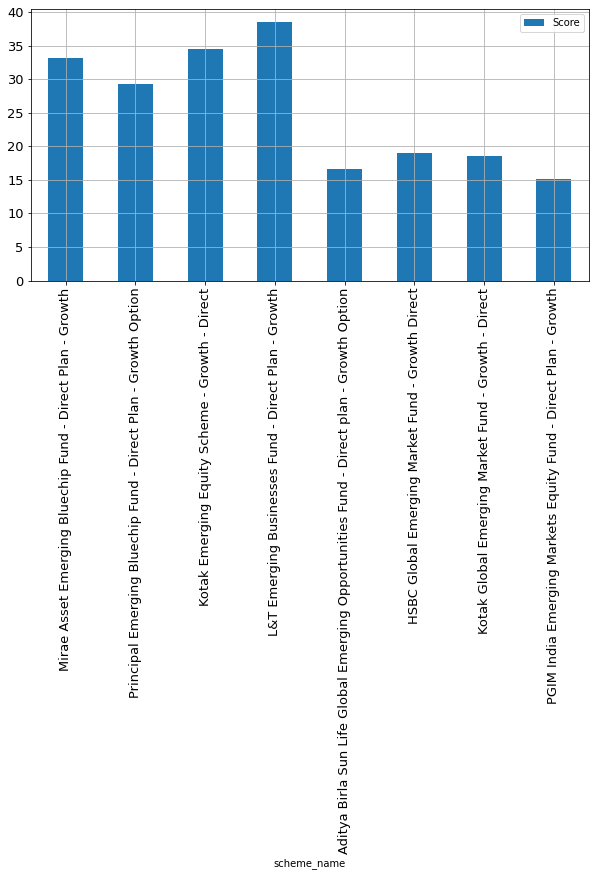

In [33]:
sel_mf['Score'].plot(kind='bar',stacked=False,figsize=(10,5), fontsize=13, grid=True,legend=True)

<AxesSubplot:xlabel='scheme_name'>

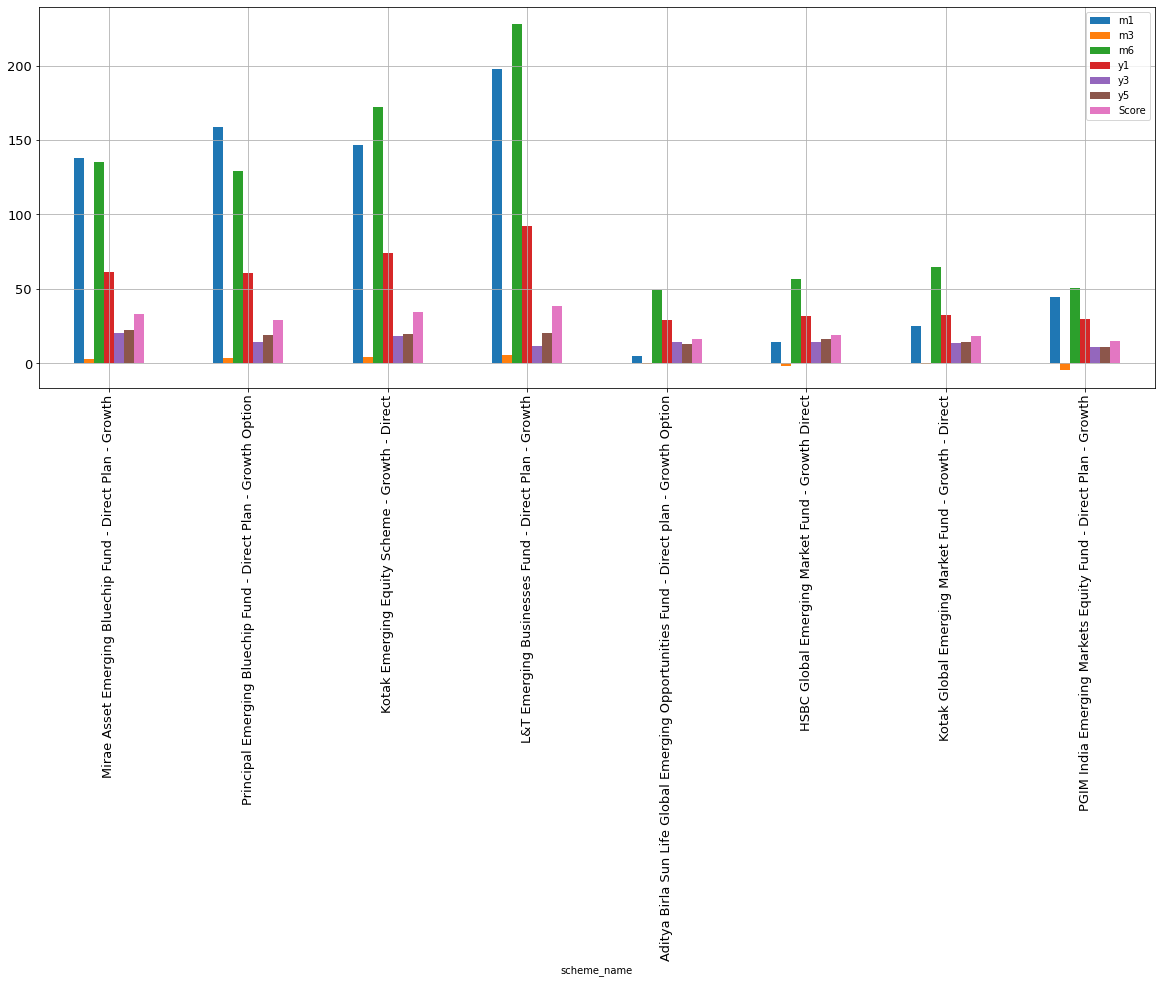

In [34]:
import matplotlib as plt
plt.figsize=(20,20)
sel_mf.plot(kind='bar',stacked=False,figsize=(20,7), fontsize=13, grid=True,legend=True)

### Selecting top 5 out of the above list

In [35]:
sel_mf = sel_mf.iloc[0:5]
sel_mf.reset_index(inplace=True)

In [36]:
sel_mf.set_index('scheme_code',inplace=True)
sel_mf

,scheme_name,last_updated,nav,m1,m3,m6,y1,y3,y5,Score
scheme_code,,,,,,,,,,
118834,Mirae Asset Emerging Bluechip Fund - Direct Pl...,07-Jun-2021,93.301,138.099737,2.790333,135.179793,61.406453,20.375444,22.694702,33.176124
119441,Principal Emerging Bluechip Fund - Direct Plan...,07-Jun-2021,171.66,158.895034,3.623506,129.414532,60.835754,14.021526,19.021191,29.263156
119775,Kotak Emerging Equity Scheme - Growth - Direct,07-Jun-2021,69.648,146.418715,3.998107,172.165183,74.146122,18.116144,19.430258,34.478626
129220,L&T Emerging Businesses Fund - Direct Plan - G...,07-Jun-2021,38.415,197.643613,5.603719,227.670909,92.094209,11.417686,20.282001,38.580530
132140,Aditya Birla Sun Life Global Emerging Opportun...,07-Jun-2021,20.0389,4.744430,-0.327193,49.576278,29.258208,14.293654,12.685373,16.568809


In [37]:
top_mf = mf_df[mf_df.index.isin(sel_mf.index)]
top_mf['scheme_name'].unique()

array(['Mirae Asset Emerging Bluechip Fund - Direct Plan - Growth',
       'Principal Emerging Bluechip Fund - Direct Plan - Growth Option',
       'Kotak Emerging Equity Scheme - Growth - Direct',
       'L&T Emerging Businesses Fund - Direct Plan - Growth',
       'Aditya Birla Sun Life Global Emerging Opportunities Fund - Direct plan - Growth Option'],
      dtype=object)

In [38]:
top_mf

,date,nav,scheme_name,fund_house,scheme_type,scheme_category,scheme_start_date.date,scheme_start_date.nav
scheme_code,,,,,,,,
118834,2021-06-07,93.3010,Mirae Asset Emerging Bluechip Fund - Direct Pl...,Mirae Asset Mutual Fund,Open Ended Schemes,Equity Scheme - Large & Mid Cap Fund,2013-01-02,14.1050
118834,2021-06-04,92.6030,Mirae Asset Emerging Bluechip Fund - Direct Pl...,Mirae Asset Mutual Fund,Open Ended Schemes,Equity Scheme - Large & Mid Cap Fund,2013-01-02,14.1050
118834,2021-06-03,92.6700,Mirae Asset Emerging Bluechip Fund - Direct Pl...,Mirae Asset Mutual Fund,Open Ended Schemes,Equity Scheme - Large & Mid Cap Fund,2013-01-02,14.1050
118834,2021-06-02,91.9630,Mirae Asset Emerging Bluechip Fund - Direct Pl...,Mirae Asset Mutual Fund,Open Ended Schemes,Equity Scheme - Large & Mid Cap Fund,2013-01-02,14.1050
118834,2021-06-01,91.5730,Mirae Asset Emerging Bluechip Fund - Direct Pl...,Mirae Asset Mutual Fund,Open Ended Schemes,Equity Scheme - Large & Mid Cap Fund,2013-01-02,14.1050
...,...,...,...,...,...,...,...,...
132140,2014-10-20,12.7458,Aditya Birla Sun Life Global Emerging Opportun...,Aditya Birla Sun Life Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,2014-10-13,12.6988
132140,2014-10-17,12.7128,Aditya Birla Sun Life Global Emerging Opportun...,Aditya Birla Sun Life Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,2014-10-13,12.6988
132140,2014-10-16,12.5739,Aditya Birla Sun Life Global Emerging Opportun...,Aditya Birla Sun Life Mutual Fund,Open Ended Schemes,Other Scheme - FoF Overseas,2014-10-13,12.6988


### Checking fluctuations / volatility in selected MFs with higher score

In [39]:
from matplotlib import *
import matplotlib.pyplot as plt                                     # Importing pyplot interface to use matplotlib
import seaborn as sns                                               # Importing seaborn library for interactive visualization
%matplotlib inline

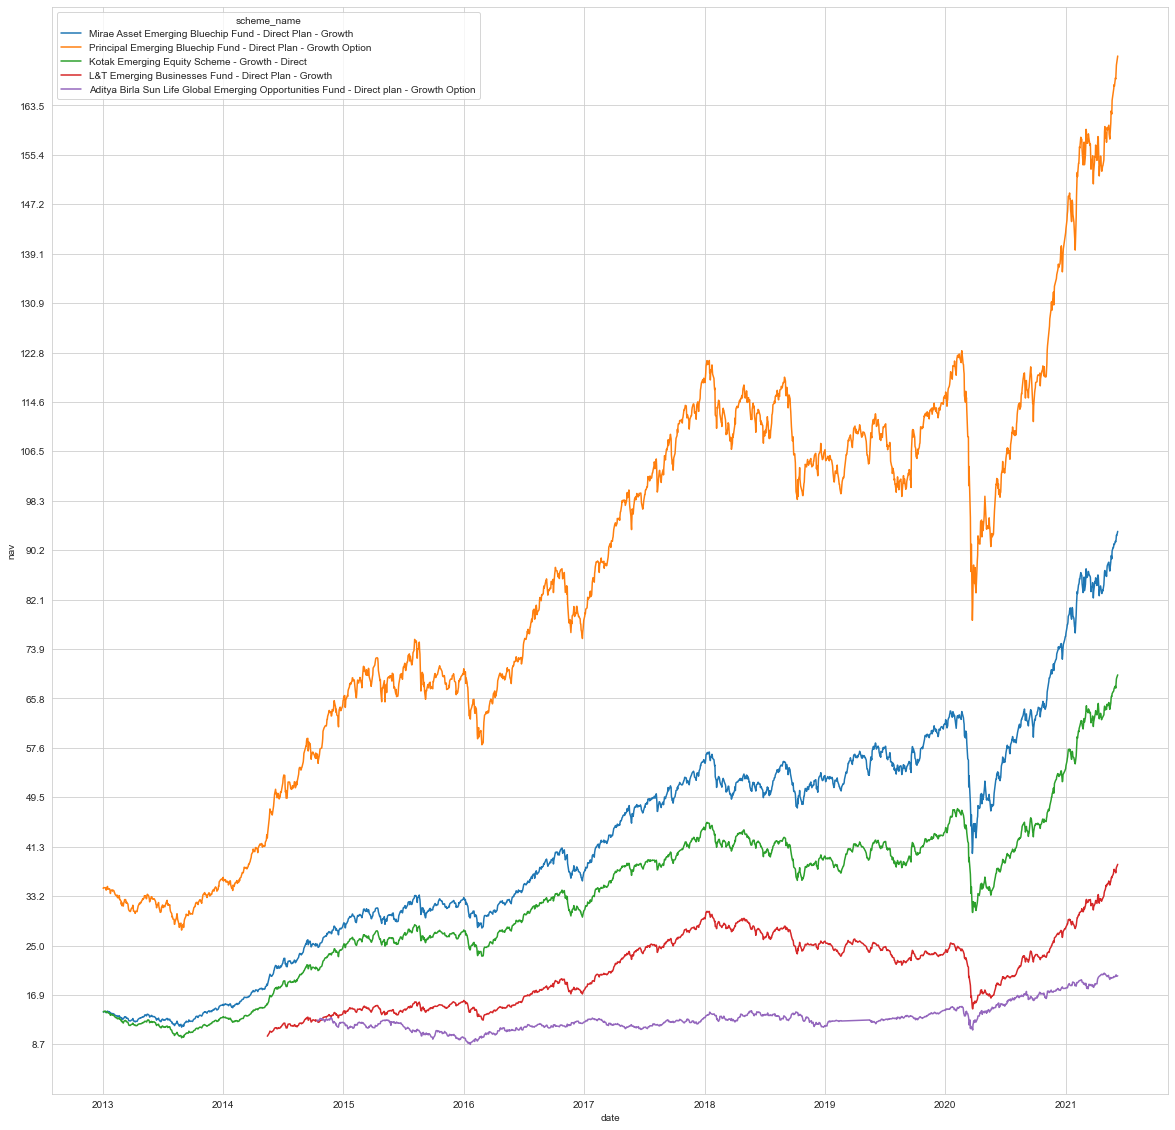

In [40]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 20))

y_min = top_mf['nav'].min()
y_max = top_mf['nav'].max()

y_ticks = np.arange(y_min, y_max, ((y_max-y_min)/20))
plt.yticks(y_ticks)

sns.lineplot(x='date',y='nav',data=top_mf,hue='scheme_name',markers=True)
plt.show()